## Imports

In [257]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [258]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn
scaler = StandardScaler()

In [259]:
def _prepare_data(df, target  = 'REARNING', 
                  cols        = None, 
                  cat_cols    = None, 
                  encode_cats = True,
                  verbose     = True):
    
    if cols is None:
        cols = df.columns
    
    categorical_features = []
    if cat_cols is not None:
        categorical_features = cat_cols #[c for c in cats if c in cols]

    valid_cols = [c for c in cols if c in df.columns]
    df_X = df[valid_cols].copy()
    for c in df_X.columns:
        df_X[c] = df_X[c].astype(float, errors='ignore')
    assert target in df_X.columns

    feature_names = [x for x in list(df_X.columns) if x!=target]

    # ordinal encode the categorical features
    le_fitted ={}
    if encode_cats:
        for feature in categorical_features:
            le                 = preprocessing.LabelEncoder()
            le_fitted[feature] = le.fit(df_X[feature].values)
            df_X[feature]      = le_fitted[feature].transform(df_X[feature])
    
        if verbose and len(categorical_features)>0:
            print("Cardinalities")
            print("=============")
            for c in categorical_features:
                print(f"{c:<25} : {len(le_fitted[c].classes_)}")
            
    return df_X, le_fitted

def _split_data(df_X, target, scaler=None, shuffle=True):
    
    X = np.array(df_X.drop(target, axis=1), dtype=float)
    y = np.array(df_X[target], dtype=float)
    
    if shuffle:
            X, y = sklearn.utils.shuffle(X, y)

    n = X.shape[0]
    n_test = int(n*0.05)
    
    if scaler:
        scaler.fit(X)
        X = scaler.transform(X)

    X_train = X[n_test:,:]
    y_train = y[n_test:]

    X_test = X[:n_test,:]
    y_test = y[:n_test]
    
    return X_train, y_train, X_test, y_test

def _regression_metrics(model, X_test, y_test, verbose=True):
    results = {}
    # how did we do?
    results['score'] =model.score(X_test, y_test) 
    if verbose:
        print(f"Score                          : {results['score']:.2f}")

    # the mean error on prediction
    results['mean_abs_err'] = np.abs(model.predict(X_test) - y_test).mean()
    if verbose:
        print(f"Average Error                  : ${results['mean_abs_err']:.0f}")

    r = (model.predict(X_test) > 50000) == (y_test > 50000)
    results['class_err'] = 100 * sum(r) / len(r)
    if verbose:
        print(f"Classification (>$50,000) acc. : {results['class_err']:.2f}")
    
    return results

In [260]:
def _load_data(ROOT):
    
    with open(os.path.join(ROOT,'USCensus1990raw.attributes.txt'), 'r') as f:
        text = f.read()
    print(text)
    
    
    sep = '__________________________________________________________________________________'

    all_codes = {}
    for t in text.split(sep)[1:]:

        lines = t.split('\n')

        colname = lines[1][:10].rstrip(' ')
        lines = [l.lstrip(' ').rstrip(' ') for l in lines[2:] if (l !='') and not l.startswith('VAR:')]
        coding = {}
        for line in lines:
            l = [l for l in line.split(' ') if l != '']
            coding[l[0]] = " ".join(l[1:])

        all_codes[colname] = coding
        
        
    cols = text.split('__________________________________________________________________________________')
    len(cols)
    cols = [c.split('\n')[1] for c in cols[1:]]
    cols = [c for c in cols if c != '']
    frame = ""
    for c in cols:
        li = [c[:10].rstrip(' '), c[13:14], c[21:22],c[28:29], c[42:].replace(",", ".")]
        if len(li) !=5:
            print(li)
        frame += r",".join(li) + "\n"


    df_meta = pd.read_csv(io.StringIO(frame), sep=',', header=None, names=['Var', 'Type', 'Des', 'Len', 'Description'])
    
    return df_meta, all_codes


df_meta, all_codes = _load_data(r"/Users/tom.jubb/Documents/data/us_census/")

                           U.S. DEPARTMENT OF COMMERCE
                                 BUREAU OF CENSUS

                          *** DATA EXTRACTION SYSTEM ***

  DOCUMENTATION OF: FILE CONTENTS

  FOR DATA COLLECTION: 'pums901p' - 1990 Decenial Census 1% PUMS - Persons Records

    VAR: = Variable Name
    TYP: = Variable Type     ( C = Categorical, N = Numeric Continuous )
    DES: = Designation       ( P = Primary Variable, X = Non-Primary )
    LEN: = Length            ( of the Variable in Characters )
    CAT: = Category          ( of the Variable )


VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
__________________________________________________________________________________
AAGE         C       X      1             Age Allocation Flag
                                  0       No
                                  1       Yes

VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
_______________________________________________________________

In [261]:
def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]

### Load and Prepare Data

In [364]:
df = pd.read_csv('us_census_data_cleaned_4.csv').drop('Unnamed: 0', axis=1)

In [365]:
TARGET = 'REARNING'

# exclude irrelevant data
df = df[df['AGE']      > 18]
df = df[df['AGE']      < 90]

df = df[df['REARNING'] > 5000]
df = df[df['REARNING'] < 140000]

In [366]:
# drop RSPOUSE, since MARITAL provides duplicate information
df =df.drop('RSPOUSE', axis=1)

In [367]:
def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    
    mapper = {k:map_to for k in gb[gb['count'] < r][col].values}
    
    return mapper, gb

mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
df['RACE'] = df['RACE'].apply(lambda x: mapper.get(x, x))

In [368]:
uninformative_columns = []
for c in df.columns:
    if len(df[c].unique()) == 1:
        print(c)
        uninformative_columns += [c]
df = df.drop(uninformative_columns, axis=1)

WORK89


In [369]:
print(f"Rows: {df.shape[0]} Features: {df.shape[1]}")

Rows: 111467 Features: 54


## Decide on Features

In [347]:
# identify numerical columns -> those which have a distance measure
num_cols = [
    'AGE',
    'YEARWRK',
    'FERTIL',
    'HOUR89',
    'HOURS',
    'RIDERS',
    'WEEK89', 
    'TRAVTIME',
    'YRSSERV',
    'REARNING',
    'INCOME1',
    'PWGT1',
    'DEPART',
    'RIDERS',
    'TRAVTIME'
]

cats = [c for c in df.columns if c not in num_cols]

In [348]:
print("===== FEATURE LIST ======")
for x in list(df.columns):
    
    try:
        vartype = 'NUM' if x in num_cols else 'CAT'
        if vartype == 'CAT':
            card = len(df[x].unique())
            print(f"{x:<20} - {vartype} - {card:<4} - {describe_feature(x)}")
        else:
            print(f"{x:<20} - {vartype} -      - {describe_feature(x)}")
    except:
        print(x)

===== FEATURE LIST ======
AGE                  - NUM -      - Age
ANCSTRY1             - CAT - 229  - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - CAT - 157  - Ancestry Second Entry See Appendix I Anc
CITIZEN              - CAT - 2    - Citizenship
CLASS                - CAT - 8    - Class of Worker
DEPART               - NUM -      - Time of Departure for Work Hour and Minu
DISABL1              - CAT - 2    - Work Limitation Stat.
ENGLISH              - CAT - 4    - Ability to Speak English
FEB55                - CAT - 2    - Served February 1955 July 1964
FERTIL               - NUM -      - No. of Chld. Ever Born
HISPANIC             - CAT - 52   - Detailed Hispanic Origin Code See Append
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - NUM -      - Hrs. Worked Last Week
IMMIGR               - CAT - 11   - Yr. of Entry
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
KOREAN               - CAT - 2  

In [349]:
df.head()

AGE  ANCSTRY1  ANCSTRY2  CITIZEN                                    CLASS  \
0   30       999       999     True       Local Gov. Emp. City, County, Etc.   
1   44       999       999     True  Emp. of a Private for Profit Company or   
2   47        50       999     True       Local Gov. Emp. City, County, Etc.   
3   42       615       999    False  Self Emp. in Own Not Incorp.d Business,   
4   52       210       999     True                           Fed. Gov. Emp.   

   DEPART  DISABL1  ENGLISH  FEB55  FERTIL  ...  WORKLWK  WWII  YEARSCH  \
0     480        2        1      0       3  ...     True     0       11   
1     330        2        1      0       0  ...     True     0       11   
2     870        2        1      1       0  ...     True     0       11   
3     420        2        1      0       0  ...     True     0       16   
4     300        2        1      1       0  ...     True     0       13   

   YRSSERV                               YEARSCH_CAT  \
0        0                 Some Coll., But No Degree   
1        0                 Some Coll., But No Degree   
2        2                 Some Coll., But No Degree   
3        0                       Professional Degree   
4        9  Associate Degree in Coll., Academic Prog   

                                           OCCUP_JOB  \
0                                 Cooks (5214, 5215)   
1                           Electricians (part 6432)   
2       Police and detectives, public service (5132)   
3                                   Physicians (261)   
4  Production inspectors, checkers, and examiners...   

                                           OCCUP_SUM  \
0                                SERVICE OCCUPATIONS   
1  PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPA...   
2                                SERVICE OCCUPATIONS   
3  MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS   
4               OPERATORS, FABRICATORS, AND LABORERS   

                                           OCCUP_MAJ  \
0  Service Occupations, Except Protective and Hou...   
1                                Construction Trades   
2                     Protective Service Occupations   
3                 Professional Specialty Occupations   
4      Machine Operators, Assemblers, and Inspectors   

                                   INDUSTRY_CAT  \
0        Elementary and secondary schools (821)   
1                     CONSTRUCTION (15, 16, 17)   
2        Justice, public order, and safety (92)   
3  Offices and clinics of physicians (801, 803)   
4                Electric light and power (491)   

                                        INDUSTRY_SUM  
0                  PROFESSIONAL AND RELATED SERVICES  
1                          CONSTRUCTION (15, 16, 17)  
2                              PUBLIC ADMINISTRATION  
3                  PROFESSIONAL AND RELATED SERVICES  
4  TRANSPORTATION, COMMUNICATIONS, AND OTHER PUBL...  

[5 rows x 55 columns]

In [350]:
keep_cols = [
    'REARNING',
#     'OCCUP',
#     'INDUSTRY',
    'RACE',
    'SEX',
    'HOURS',
    'AGE',
    'FERTIL',
    'WEEK89',
    'MARITAL',
    'ENGLISH',
    'YRSSERV',
    'MEANS',
    'CITIZEN',
    'YEARSCH',
    'CLASS',
    'DEPART',
    
#     'WORKLWK',
#     'MILITARY',  
#     'SEPT80',
#     'WWII',
#     'SCHOOL',
#     'POWSTATE',
    'PWGT1',
#     'RIDERS',
#     'VIETNAM',
#     'KOREAN',
#     'multilingual'
    
    'OCCUP_JOB',
    'OCCUP_SUM',
    'OCCUP_MAJ',
    'INDUSTRY_CAT',
    'INDUSTRY_SUM',
]

## Advanced Feature Engineering : PCA

In [117]:
from sklearn.decomposition import PCA

pca = PCA(16)

In [118]:
# df_X, _ = _prepare_data(df, 
#                     target      = TARGET, 
#                     cols        = df.columns, 
#                     cat_cols    = [c for c in keep_cols if c not in num_cols], 
#                     encode_cats = True,
#                     verbose     = False)

In [116]:
df_X, _ = _prepare_data(df, 
                    target      = TARGET, 
                    cols        = keep_cols, 
                    cat_cols    = [c for c in keep_cols if c not in num_cols], 
                    encode_cats = True,
                    verbose     = True)

Cardinalities
CITIZEN                   : 2
CLASS                     : 8
ENGLISH                   : 4
MARITAL                   : 5
MEANS                     : 12
RACE                      : 62
SEX                       : 2
YEARSCH                   : 17
OCCUP_JOB                 : 494
OCCUP_SUM                 : 7
OCCUP_MAJ                 : 14
INDUSTRY_CAT              : 238
INDUSTRY_SUM              : 14


In [120]:
# split data into inputs and outputs (truth)
# df_X = df_encoded.copy()
X_pca = np.array(df_X.drop(TARGET, axis=1), dtype=float)

# note PCA is sensitive to magnitude, so standard scaler must be applied
scaler.fit(X_pca)
X_pca = scaler.transform(X_pca)

feature_names = [x for x in list(df_X.columns) if x!=TARGET]

X_pca = pca.fit_transform(X_pca)

c=0.0
for a,b in zip(pca.get_feature_names_out(), pca.explained_variance_ratio_):
    c += b
    print(f"{a:<12} - {100*b:<6.3f} - {100*c:.3f}")

pca0         - 15.357 - 15.357
pca1         - 11.937 - 27.294
pca2         - 9.028  - 36.322
pca3         - 7.600  - 43.923
pca4         - 7.016  - 50.939
pca5         - 6.671  - 57.610
pca6         - 5.809  - 63.419
pca7         - 5.649  - 69.068
pca8         - 5.381  - 74.449
pca9         - 5.132  - 79.582
pca10        - 4.938  - 84.519
pca11        - 4.418  - 88.938
pca12        - 3.748  - 92.686
pca13        - 3.348  - 96.033
pca14        - 2.780  - 98.813
pca15        - 1.187  - 100.000


In [121]:
for p, k in zip(pca.components_[0], [c for c in keep_cols if c != TARGET]):
    print(f"{p:<7.2f}, {k}")

0.44   , OCCUP
-0.42  , INDUSTRY
-0.01  , RACE
0.31   , SEX
0.04   , HOURS
-0.10  , AGE
-0.25  , FERTIL
-0.06  , WEEK89
0.01   , MARITAL
0.38   , ENGLISH
-0.05  , YRSSERV
-0.02  , MEANS
-0.31  , CITIZEN
-0.42  , YEARSCH
-0.18  , CLASS
-0.03  , DEPART


## Attempt 1 : Basic Model, All Data

- Linear regression is a very simple and explaianable model
- Let's use all the data

In [370]:
cols = [d for d in df.columns if d not in ['MIGSTATE', 'POWSTATE']]

df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = cols, 
                        cat_cols    = [c for c in cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows: {df_X.shape[0]} Features: {df_X.shape[1]}")

Rows: 111467 Features: 52


In [377]:
# scale features so we can compare the size of the coefficients
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

Training data : 105894 
Test data     : 5573


In [378]:
reg = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(reg, X_test, y_test)

Score                          : 0.35
Average Error                  : $9281
Classification (>$50,000) acc. : 94.19


#### Sample multiple test sets to find model error

In [379]:
results = []
coefs   = []
for i in range(10):
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target=TARGET, 
                                                   scaler=scaler, 
                                                   shuffle=True)
    reg = LinearRegression().fit(X_train, y_train)
    coefs   += [reg.coef_]
    results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
    
err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

Error : $9230.02 +/- 117.20


In [380]:
xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_, yvals_err_ = np.array(coefs).mean(axis=0), np.array(coefs).std(axis=0)

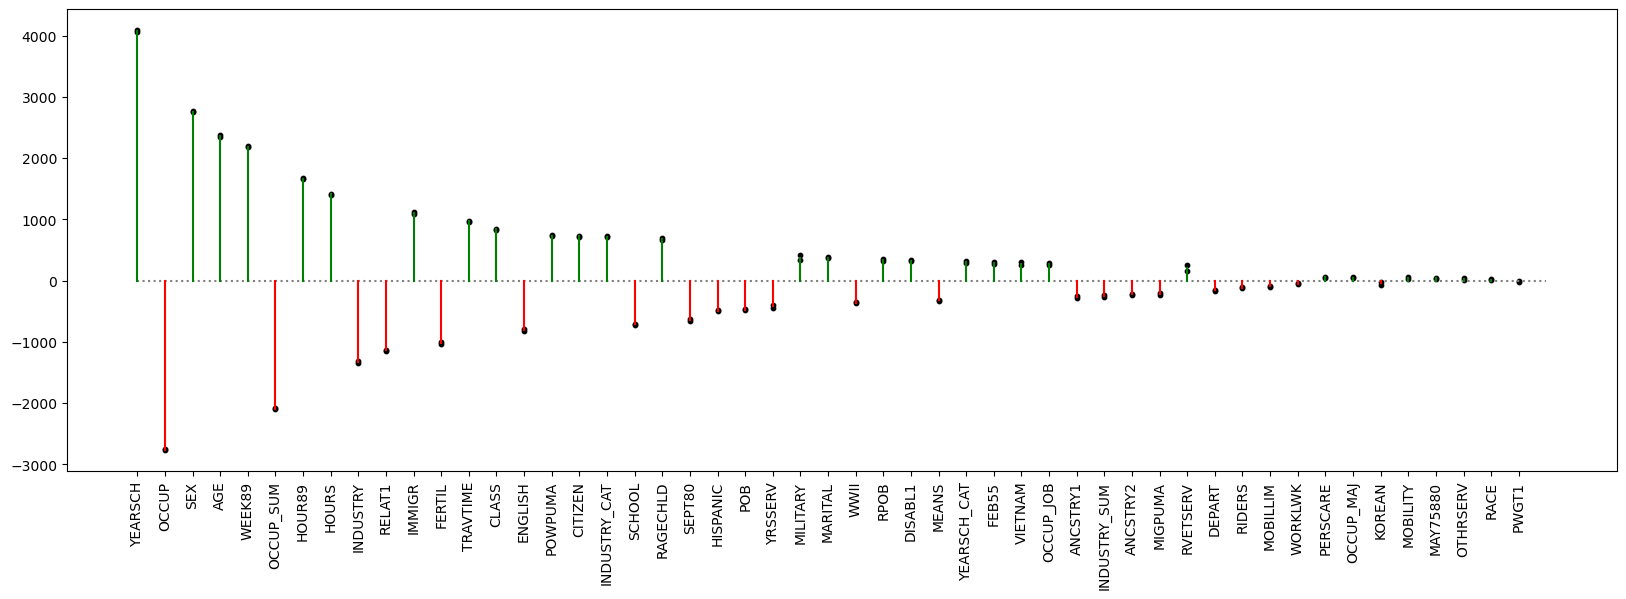



MOST IMPORTANT FEATURES

AGE        2339.30    Age
OCCUP      -2766.81   Occupation See Appendix I Occup.lst
SEX        2772.04    Sex
WEEK89     2197.87    Wks. Worked Last Yr. 1989
YEARSCH    4058.00    Ed. Attainment
OCCUP_SUM  -2094.25   


LEAST IMPORTANT FEATURES

KOREAN     -28.83     Served Korean Conflict June 1950 January
MAY75880   33.85      Served May 1975 to August 1980
MOBILITY   32.21      Mobility Stat. Lived Here on April 1. 19
OTHRSERV   14.20      Served Any Other Time
PWGT1      -17.00     Pers. Wgt
RACE       13.61      Recoded Detailed Race Code Appendix C Ra
WORKLWK    -48.08     Worked Last Week
OCCUP_MAJ  46.99      


In [381]:
fig, ax = plt.subplots(1,1,figsize=(20,6))

# yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals     = np.array([xvals_[i] for i in idx])
yvals     = np.array([yvals_[i] for i in idx])
yvals_err = np.array([yvals_err_[i] for i in idx])

plt.scatter(xvals, yvals - yvals_err, color="black", s=10)
plt.scatter(xvals, yvals + yvals_err, color="black", s=10)

plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
    
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

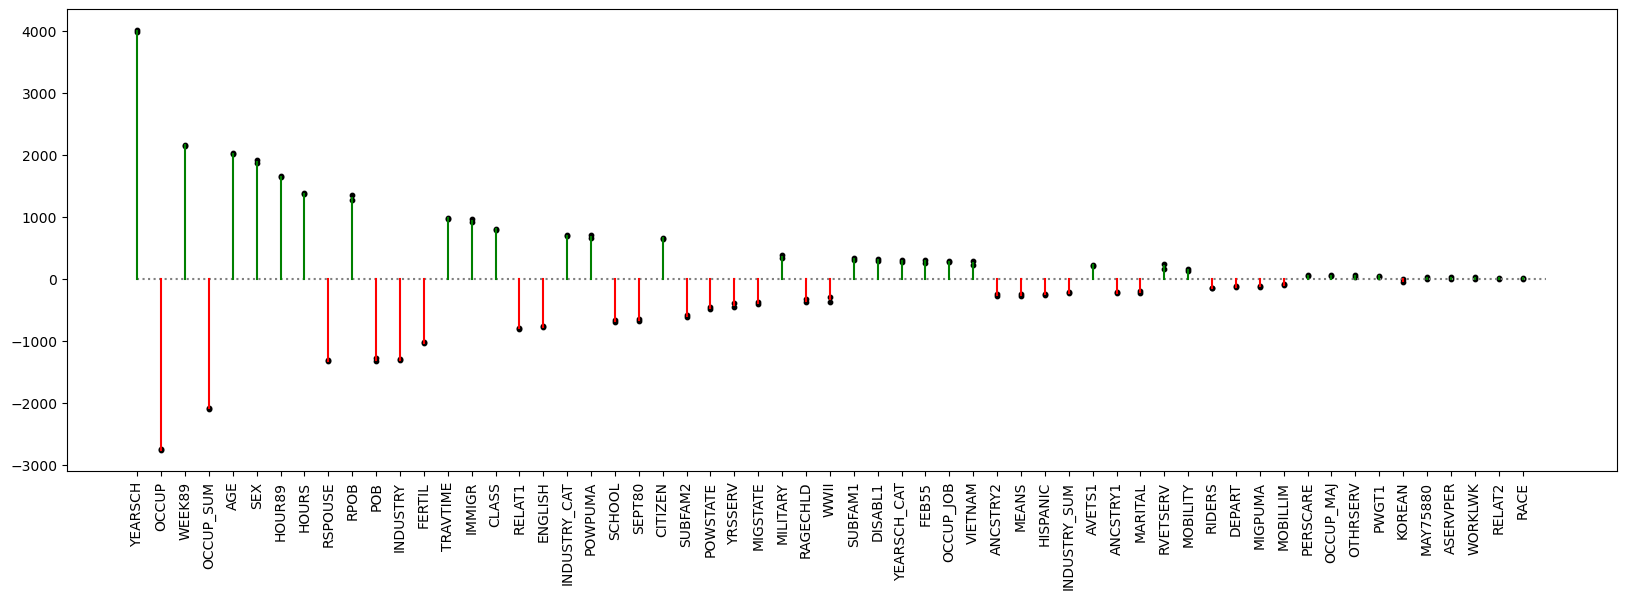



MOST IMPORTANT FEATURES

AGE        2028.80    Age
OCCUP      -2754.98   Occupation See Appendix I Occup.lst
WEEK89     2145.91    Wks. Worked Last Yr. 1989
YEARSCH    4016.08    Ed. Attainment
OCCUP_SUM  -2076.78   


LEAST IMPORTANT FEATURES

ASERVPER   32.88      Military Per. of Srvc. Allocation Flag
KOREAN     9.26       Served Korean Conflict June 1950 January
MAY75880   34.07      Served May 1975 to August 1980
PWGT1      39.81      Pers. Wgt
RACE       16.80      Recoded Detailed Race Code Appendix C Ra
RELAT2     4.47       Detailed Rel. Other Rel.
WORKLWK    -5.90      Worked Last Week


#### More selective over columns

In [388]:
keep_cols = [
    'REARNING',
    'OCCUP',
    'INDUSTRY',
    'RACE',
    'SEX',
    'HOURS',
    'AGE',
    'FERTIL',
    'WEEK89',
    'MARITAL',
    'ENGLISH',
    'YRSSERV',
    'MEANS',
    'CITIZEN',
    'YEARSCH',
    'CLASS',
    'DEPART',
    
    'WORKLWK',
    'MILITARY',  
    'SEPT80',
    'WWII',
    'SCHOOL',
    'POWSTATE',
    'PWGT1',
    'RIDERS',
    'VIETNAM',
    'KOREAN',

    'OCCUP_JOB',
    'OCCUP_SUM',
    'OCCUP_MAJ',
    'INDUSTRY_CAT',
    'INDUSTRY_SUM',
]

Rows          : 111467 Features: 32
Training data : 105894 
Test data     : 5573
Score                          : 0.32
Average Error                  : $9372
Classification (>$50,000) acc. : 94.44


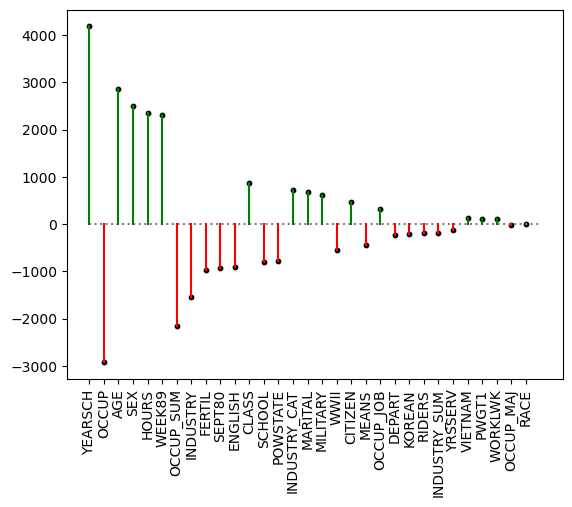



MOST IMPORTANT FEATURES

YEARSCH    4183.17    Ed. Attainment
OCCUP      -2930.22   Occupation See Appendix I Occup.lst
AGE        2869.12    Age
SEX        2506.25    Sex
HOURS      2347.30    Hrs. Worked Last Week


LEAST IMPORTANT FEATURES

VIETNAM    119.32     Served Vietnam Era August 1964 April 197
PWGT1      107.81     Pers. Wgt
WORKLWK    99.22      Worked Last Week
OCCUP_MAJ  -15.91     
RACE       10.68      Recoded Detailed Race Code Appendix C Ra


In [389]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

reg = LinearRegression().fit(X_train, y_train)
_regression_metrics(reg, X_test, y_test)

# plt.scatter([c for c in df_X.columns if c !=TARGET], reg.coef_, color="black", s=10)
# plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
# for c, coef in zip(range(df_X.shape[1]-1), reg.coef_):
#     color = 'g' if coef>0 else 'r'
#     plt.plot([c,c],[0,coef], color=color)
# plt.xticks(rotation=90)
# plt.show()


xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx]
yvals = [yvals_[i] for i in idx]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[-5:][::-1]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[::-1][-5:]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

#### Use dummy variables for cats

TODO : remove rare categories from high cardinality vars

======= Results ========
Score                          : 0.40
Average Error                  : $8728
Classification (>$50,000) acc. : 94.65


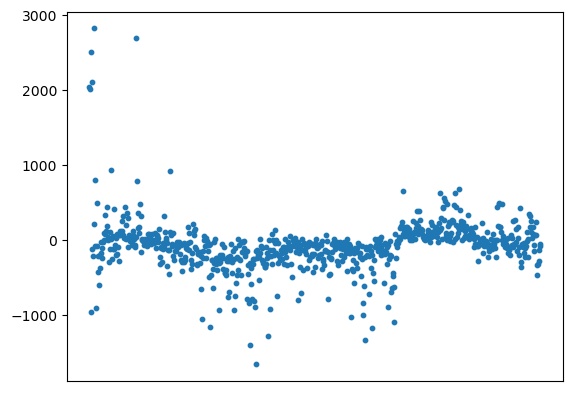

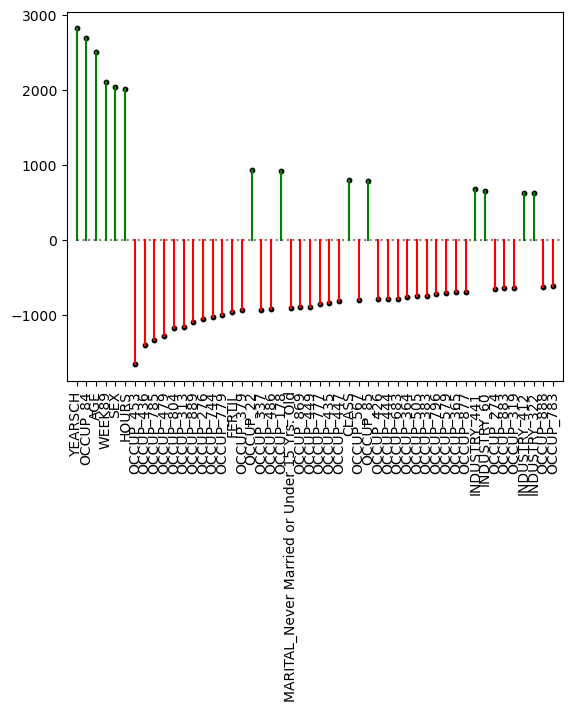



MOST IMPORTANT FEATURES

SEX        -2930.22   Sex
FERTIL     2506.25    No. of Chld. Ever Born
WEEK89     2347.30    Wks. Worked Last Yr. 1989
YRSSERV    2869.12    Yrs. of Active Duty Military Srvc.
CITIZEN    2300.95    Citizenship
MARITAL_Separated 4183.17    
OCCUP_8    -2158.53   


LEAST IMPORTANT FEATURES

AGE        10.68      Age
OCCUP_9    -15.91     


In [390]:
keep_cols = [
    'REARNING',
    'OCCUP',
    'INDUSTRY',
    'RACE',
    'SEX',
    'HOURS',
    'AGE',
    'FERTIL',
    'WEEK89',
    'MARITAL',
    'ENGLISH',
    'YRSSERV',
    'MEANS',
    'CITIZEN',
    'YEARSCH',
    'CLASS',
    'DEPART'
]

df_dummy = pd.get_dummies(df[keep_cols],
                          columns=['MARITAL', 
                                   'ENGLISH', 
                                   'RACE', 
                                   'OCCUP',
                                   'INDUSTRY'], 
                          drop_first=True)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

In [247]:
describe_feature('AVETS1')

'Military Srvc. Allocation Flag'

(111467, 154)
======= Results ========
Score                          : 0.36
Average Error                  : $9266
Classification (>$50,000) acc. : 93.83


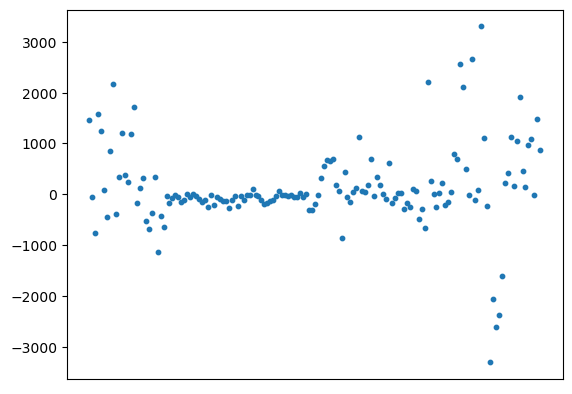

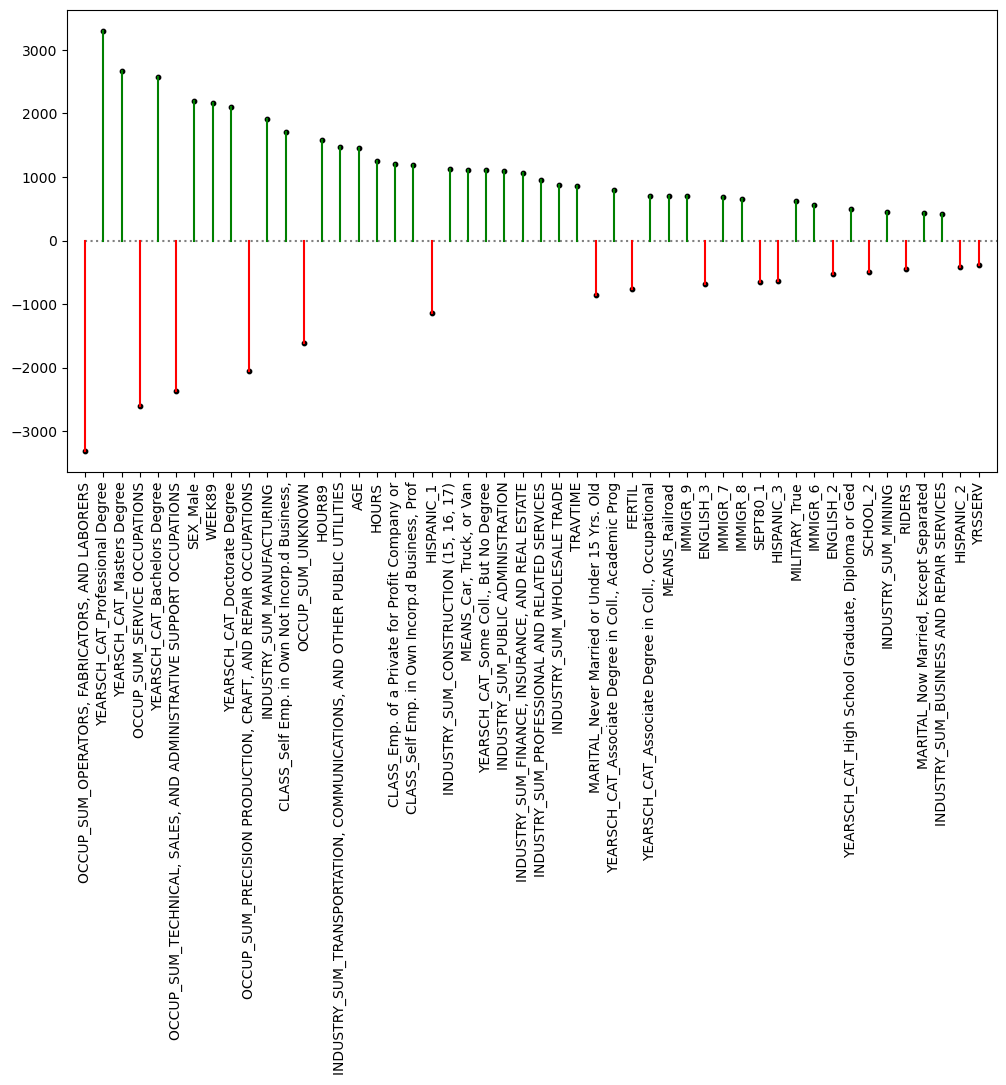



MOST IMPORTANT FEATURES

WEEK89     2164.94    Wks. Worked Last Yr. 1989
SEX_Male   2201.84    
YEARSCH_CAT_Bachelors Degree 2568.75    
YEARSCH_CAT_Doctorate Degree 2100.56    
YEARSCH_CAT_Masters Degree 2670.05    
YEARSCH_CAT_Professional Degree 3303.79    
OCCUP_SUM_OPERATORS, FABRICATORS, AND LABORERS -3307.17   
OCCUP_SUM_PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPATIONS -2059.82   
OCCUP_SUM_SERVICE OCCUPATIONS -2604.90   
OCCUP_SUM_TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT OCCUPATIONS -2371.15   


LEAST IMPORTANT FEATURES

HISPANIC_4 -28.26     
HISPANIC_203 -18.03     
HISPANIC_212 0.89       
HISPANIC_215 -2.81      
HISPANIC_218 -43.24     
HISPANIC_225 -16.54     
HISPANIC_227 -47.37     
HISPANIC_236 -24.95     
HISPANIC_238 -26.72     
HISPANIC_249 -20.02     
HISPANIC_250 -13.22     
HISPANIC_252 -14.47     
HISPANIC_261 -36.25     
HISPANIC_296 -27.79     
HISPANIC_302 -13.79     
HISPANIC_303 -9.77      
HISPANIC_304 -26.63     
HISPANIC_310 -19.66     
HISPANI

In [391]:
drop_cols = [
     'OCCUP', 
     'INDUSTRY',
     'OCCUP_JOB',
     'OCCUP_MAJ',
     'INDUSTRY_CAT',
     'ANCSTRY1',
     'ANCSTRY2',
     'RELAT1',
     'RELAT2',
     'ASERVPER',
     'AVETS1',
    
     'POB',
     'RPOB',
     'MIGPUMA',
     'POWPUMA',
     'MIGSTATE',
     'POWSTATE',
     'RAGECHLD',
    
     'RELAT2',
     'SUBFAM1',
     'SUBFAM2',
     
     'RSPOUSE',  
     'RVETSERV', # duplicate the other military categories
     'YEARSCH',  # duplicate
]

keep_cols = [d for d in df.columns if d not in drop_cols]

df_dummy = pd.get_dummies(df[keep_cols],
                          columns=[c for c in keep_cols if c not in num_cols], 
                          drop_first=True)
print(df_dummy.shape)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]

fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((model.coef_ > 2000) | (model.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(model.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")

## Attempt 2 

- All data, different models

In [392]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None, 
                        cat_cols    = [c for c in df.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

Cardinalities
ANCSTRY1                  : 229
ANCSTRY2                  : 157
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 4
FEB55                     : 2
HISPANIC                  : 52
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 494
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 251
POWPUMA                   : 105
POWSTATE                  : 52
RACE                      : 6
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SCHOOL                    : 3
SEPT80                    : 2
SEX 

In [395]:
model = LinearRegression().fit(X_train, y_train)
print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.35
Average Error                  : $9134
Classification (>$50,000) acc. : 94.28


In [396]:
model = GradientBoostingRegressor(n_estimators  =100, 
                                  learning_rate =1.0,
#                                 max_depth     =5, 
                                  random_state  = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.44
Average Error                  : $8183
Classification (>$50,000) acc. : 94.51


In [397]:
models = []
models.append(('LR',   LinearRegression()))
models.append(('GBR',  GradientBoostingRegressor()))
models.append(('DTR',  DecisionTreeRegressor()))
models.append(('RFR',  RandomForestRegressor()))


for name, model in models:
    model.fit(X_train, y_train)
    print("======= Results ========")
    _ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.35
Average Error                  : $9134
Classification (>$50,000) acc. : 94.28
======= Results ========
Score                          : 0.46
Average Error                  : $8107
Classification (>$50,000) acc. : 94.69
======= Results ========
Score                          : -0.19
Average Error                  : $11582
Classification (>$50,000) acc. : 90.79
======= Results ========
Score                          : 0.46
Average Error                  : $8153
Classification (>$50,000) acc. : 94.38


#### Gradient boosting offers us another way to observe feature importance

In [398]:
model = GradientBoostingRegressor(n_estimators  =150, 
                                  learning_rate =0.1,
                                  random_state  = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)
print('\n')

importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

======= Results ========
Score                          : 0.47
Average Error                  : $7994
Classification (>$50,000) acc. : 94.78


OCCUP      - 0.244 - 0.24 - Occupation See Appendix I Occup.lst
YEARSCH    - 0.230 - 0.47 - Ed. Attainment
AGE        - 0.093 - 0.57 - Age
RELAT1     - 0.069 - 0.64 - Rel. or Not Related or Grp. Qtrs.
HOUR89     - 0.062 - 0.70 - Usual Hrs. Worked Per Week Last Yr. 1989
WEEK89     - 0.055 - 0.75 - Wks. Worked Last Yr. 1989
SEX        - 0.028 - 0.78 - Sex
HOURS      - 0.022 - 0.80 - Hrs. Worked Last Week
INDUSTRY   - 0.021 - 0.82 - Ind. See Appendix I Ind..lst
FERTIL     - 0.020 - 0.84 - No. of Chld. Ever Born
ANCSTRY1   - 0.016 - 0.86 - Ancestry First Entry See Appendix I Ance
ENGLISH    - 0.015 - 0.88 - Ability to Speak English
RAGECHLD   - 0.011 - 0.89 - Presence and Age of Own Chld.
IMMIGR     - 0.011 - 0.90 - Yr. of Entry
CLASS      - 0.010 - 0.91 - Class of Worker
OCCUP_JOB  - 0.010 - 0.92 - 
POWPUMA    - 0.009 - 0.93 - Place of Work Puma St

## Attempt 2

- PCA used to determine features with most influence
- Categorical variable identified using EDA

In [64]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

Cardinalities
CITIZEN                   : 2
CLASS                     : 8
ENGLISH                   : 4
MARITAL                   : 5
MEANS                     : 12
RACE                      : 62
SEX                       : 2
YEARSCH                   : 17
OCCUP_JOB                 : 494
OCCUP_SUM                 : 7
OCCUP_MAJ                 : 14
INDUSTRY_CAT              : 238
INDUSTRY_SUM              : 14




In [65]:
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.28
Average Error                  : $9505
Classification (>$50,000) acc. : 94.93


In [66]:
model = GradientBoostingRegressor(n_estimators    =100, 
                                  learning_rate   =1.0,
                                  random_state    = 0).fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.41
Average Error                  : $8422
Classification (>$50,000) acc. : 95.07


In [68]:
importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

YEARSCH    - 0.362 - 0.36 - Ed. Attainment
AGE        - 0.134 - 0.50 - Age
FERTIL     - 0.115 - 0.61 - No. of Chld. Ever Born
OCCUP_SUM  - 0.071 - 0.68 - 
WEEK89     - 0.070 - 0.75 - Wks. Worked Last Yr. 1989
HOURS      - 0.054 - 0.81 - Hrs. Worked Last Week
OCCUP_JOB  - 0.039 - 0.85 - 
INDUSTRY_SUM - 0.024 - 0.87 - 
ENGLISH    - 0.021 - 0.89 - Ability to Speak English
INDUSTRY_CAT - 0.018 - 0.91 - 
CLASS      - 0.017 - 0.92 - Class of Worker
CITIZEN    - 0.013 - 0.94 - Citizenship
PWGT1      - 0.013 - 0.95 - Pers. Wgt
RACE       - 0.013 - 0.96 - Recoded Detailed Race Code Appendix C Ra
OCCUP_MAJ  - 0.011 - 0.98 - 
SEX        - 0.006 - 0.98 - Sex
MEANS      - 0.006 - 0.99 - Means of Transportation to Work
MARITAL    - 0.005 - 0.99 - Marital Stat.
DEPART     - 0.005 - 1.00 - Time of Departure for Work Hour and Minu
YRSSERV    - 0.004 - 1.00 - Yrs. of Active Duty Military Srvc.


In [530]:
keep_cols_0 = [
    'REARNING',
    'OCCUP']

test_cols=[
    'INDUSTRY',
    'RACE',
    'SEX',
    'HOURS',
    'AGE',
    'FERTIL',
    'WEEK89',
    'MARITAL',
    'ENGLISH',
    'YRSSERV',
    'MEANS',
    'CITIZEN',
    'YEARSCH',
    'CLASS',
    'DEPART',    
    'WORKLWK',
    'MILITARY',  
    'SEPT80',
    'WWII',
    'SCHOOL',
    'POWSTATE',
    'PWGT1',
    'RIDERS',
    'VIETNAM',
    'KOREAN',
    'multilingual'
]

keep_cols_1 = keep_cols_0

baseline = 0.0
for t in test_cols:
    keep_cols_1 += [t]
    print(keep_cols_1)
    
    tmp = [c for c in keep_cols_1 if c != TARGET]
    tmp = [True if c not in num_cols else False for c in tmp]
    
    gb = df.groupby('OCCUP').count().sort_values('AGE')['AGE']
    low_occup_codes = set(list(gb[gb < 100].index))
    repl = min(low_occup_codes)

    df_2 = df.copy()
    # df_2 = df_2[df['OCCUP'].apply(lambda x: x not in low_occup_codes)]
    df_2['OCCUP'] = df['OCCUP'].apply(lambda x: repl if x in low_occup_codes else x)
    
    df_X, _ = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols_1, 
                            cat_cols    = [c for c in keep_cols_1 if c not in num_cols], 
                            encode_cats = True,
                            verbose     = False)
    print('\n')

    X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

    print("======= Results ========")
    _regression_metrics(model, X_test, y_test)
    
    score = model.score(X_test, y_test)
    if score >= baseline:
        # keep
        baseline = score
    else:
        # reject
        keep_cols_1 = keep_cols_1[:-1]

['REARNING', 'OCCUP', 'INDUSTRY']


======= Results ========
Score                          : 0.29
Average Error                  : $9290
Classification (>$50,000) acc. : 95.15
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE']


======= Results ========
Score                          : 0.31
Average Error                  : $9107
Classification (>$50,000) acc. : 94.98
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE', 'SEX']


======= Results ========
Score                          : 0.34
Average Error                  : $8866
Classification (>$50,000) acc. : 95.15
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE', 'SEX', 'HOURS']


======= Results ========
Score                          : 0.36
Average Error                  : $8691
Classification (>$50,000) acc. : 95.33
['REARNING', 'OCCUP', 'INDUSTRY', 'RACE', 'SEX', 'HOURS', 'AGE']


======= Results ========
Score                          : 0.42
Average Error                  : $8081
Classification (>$50,000) acc. : 95.38
['REARNING', 'OCCUP', 'INDUSTRY', 'RA

ValueError: categorical_features set as a boolean mask must have shape (n_features,), got: (17,)

In [531]:
keep_cols_1

['REARNING',
 'OCCUP',
 'INDUSTRY',
 'RACE',
 'SEX',
 'HOURS',
 'AGE',
 'WEEK89',
 'MARITAL',
 'ENGLISH',
 'YRSSERV',
 'YEARSCH',
 'CLASS',
 'SEPT80',
 'RIDERS',
 'VIETNAM',
 'KOREAN',
 'multilingual']

['REARNING',
 'OCCUP',
 'INDUSTRY',
 'RACE',
 'SEX',
 'HOURS',
 'AGE',
 'WEEK89',
 'MARITAL',
 'ENGLISH',
 'YEARSCH',
 'CLASS',
 'DEPART',
 'WORKLWK',
 'MILITARY',
 'SCHOOL',
 'RIDERS']

In [532]:
[t for t in test_cols if t not in keep_cols_1]

['FERTIL',
 'MEANS',
 'CITIZEN',
 'DEPART',
 'WORKLWK',
 'MILITARY',
 'WWII',
 'SCHOOL',
 'POWSTATE',
 'PWGT1']

#### Reduce the OCCUP cardinality by reducing all jobs with <100 people to a single cat

In [399]:
gb = df.groupby('OCCUP').count().sort_values('AGE')['AGE']
low_occup_codes = set(list(gb[gb < 100].index))
repl = min(low_occup_codes)

df_2 = df.copy()
# df_2 = df_2[df['OCCUP'].apply(lambda x: x not in low_occup_codes)]
df_2['OCCUP'] = df['OCCUP'].apply(lambda x: repl if x in low_occup_codes else x)

df_2 = df_2.drop('OCCUP_JOB', axis=1)

tmp = [c for c in df_2.columns if c != TARGET]
tmp = [True if c not in num_cols else False for c in tmp]

In [400]:
print(f"New cardinality {df_2.groupby('OCCUP').count().shape[0]}")

New cardinality 201


In [401]:
df_X, lecs = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = None,#keep_cols, 
                            cat_cols    = [c for c in df_2.columns if c not in num_cols],#[c for c in keep_cols if c not in num_cols], 
                            encode_cats = True,
                            verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

Cardinalities
ANCSTRY1                  : 229
ANCSTRY2                  : 157
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 4
FEB55                     : 2
HISPANIC                  : 52
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 201
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 251
POWPUMA                   : 105
POWSTATE                  : 52
RACE                      : 6
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SCHOOL                    : 3
SEPT80                    : 2
SEX 

In [402]:
model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

In [403]:
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.48
Average Error                  : $7583
Classification (>$50,000) acc. : 94.17


Score                          : 0.45
Average Error                  : $7799
Classification (>$50,000) acc. : 94.28


In [404]:
# train N times
results = []

for i in range(10):
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target=TARGET, 
                                                   scaler=None, 
                                                   shuffle=True)
    
    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)
    results += [_regression_metrics(model, X_test, y_test)]

err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

Score                          : 0.47
Average Error                  : $7746
Classification (>$50,000) acc. : 94.44
Score                          : 0.50
Average Error                  : $7761
Classification (>$50,000) acc. : 94.87
Score                          : 0.51
Average Error                  : $7576
Classification (>$50,000) acc. : 95.07
Score                          : 0.50
Average Error                  : $7695
Classification (>$50,000) acc. : 94.87
Score                          : 0.51
Average Error                  : $7756
Classification (>$50,000) acc. : 94.31
Score                          : 0.52
Average Error                  : $7481
Classification (>$50,000) acc. : 95.12
Score                          : 0.48
Average Error                  : $7554
Classification (>$50,000) acc. : 95.16
Score                          : 0.51
Average Error                  : $7656
Classification (>$50,000) acc. : 94.78
Score                          : 0.50
Average Error                  : $

## Model Tuning

In [405]:
results = []

for lr in np.linspace(0.005,0.5,25):
    print(lr)
    model = HistGradientBoostingRegressor( 
                                     learning_rate=lr,
                                     max_bins=255,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    _regression_metrics(model, X_test, y_test)
    
    results += [model.score(X_test, y_test)]

0.005
Score                          : 0.24
Average Error                  : $10399
Classification (>$50,000) acc. : 94.01
0.025625000000000002
Score                          : 0.47
Average Error                  : $8144
Classification (>$50,000) acc. : 94.74
0.04625
Score                          : 0.50
Average Error                  : $7795
Classification (>$50,000) acc. : 95.01
0.066875
Score                          : 0.50
Average Error                  : $7700
Classification (>$50,000) acc. : 94.92
0.08750000000000001
Score                          : 0.50
Average Error                  : $7709
Classification (>$50,000) acc. : 94.90
0.10812500000000001
Score                          : 0.51
Average Error                  : $7661
Classification (>$50,000) acc. : 94.94
0.12875
Score                          : 0.50
Average Error                  : $7699
Classification (>$50,000) acc. : 94.74
0.149375
Score                          : 0.51
Average Error                  : $7662
Classific

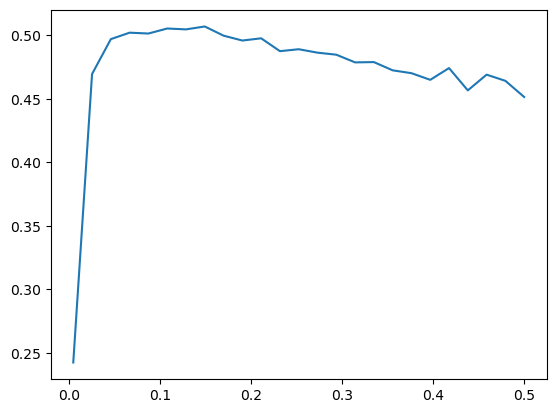

In [406]:
plt.plot(np.linspace(0.005,0.5,25), results)

In [407]:
results = []

for v in np.linspace(50,250,25):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate=0.1,
                                     max_bins=255,
                                     max_iter = int(v),
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    _regression_metrics(model, X_test, y_test)
    
    results += [model.score(X_test, y_test)]

50.0
Score                          : 0.49
Average Error                  : $7810
Classification (>$50,000) acc. : 95.01
58.333333333333336
Score                          : 0.50
Average Error                  : $7768
Classification (>$50,000) acc. : 94.98
66.66666666666667
Score                          : 0.50
Average Error                  : $7738
Classification (>$50,000) acc. : 94.99
75.0
Score                          : 0.50
Average Error                  : $7733
Classification (>$50,000) acc. : 94.92
83.33333333333334
Score                          : 0.50
Average Error                  : $7727
Classification (>$50,000) acc. : 94.96
91.66666666666667
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
100.0
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
108.33333333333334
Score                          : 0.50
Average Error                  : $7716
Cla

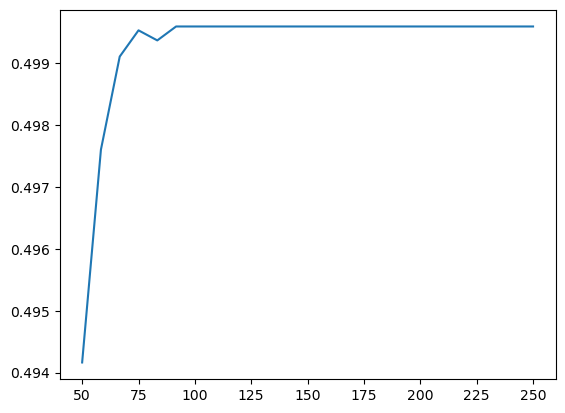

In [408]:
plt.plot(np.linspace(50,250,25), results)

50.0
Score                          : 0.44
Average Error                  : $8064
Classification (>$50,000) acc. : 95.42
58.333333333333336
Score                          : 0.44
Average Error                  : $7978
Classification (>$50,000) acc. : 95.24
66.66666666666667
Score                          : 0.45
Average Error                  : $7913
Classification (>$50,000) acc. : 95.15
75.0
Score                          : 0.45
Average Error                  : $7868
Classification (>$50,000) acc. : 95.33
83.33333333333334
Score                          : 0.45
Average Error                  : $7829
Classification (>$50,000) acc. : 95.24
91.66666666666667
Score                          : 0.46
Average Error                  : $7804
Classification (>$50,000) acc. : 95.20
100.0
Score                          : 0.46
Average Error                  : $7790
Classification (>$50,000) acc. : 95.24
108.33333333333334
Score                          : 0.46
Average Error                  : $7776
Cla

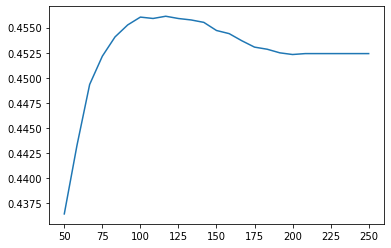

In [410]:
results = []

for v in range(10,100,9):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate=0.1,
                                     max_bins=255,
                                     max_depth = v+1 ,
                                     max_iter  = 100,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    _regression_metrics(model, X_test, y_test)
    
    results += [model.score(X_test, y_test)]

10
Score                          : 0.50
Average Error                  : $7703
Classification (>$50,000) acc. : 94.89
19
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
28
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
37
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
46
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
55
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
64
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
73
Score                          : 0.50
Average Error                  : $7716
Classification (>$50,000) acc. : 94.99
82
Score                          : 0.50
Average

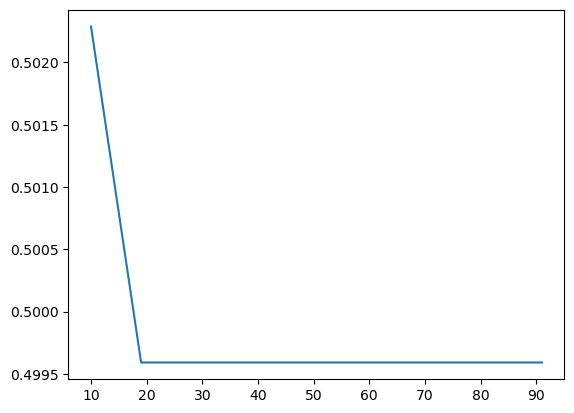

In [426]:
plt.plot(range(10,100,9), results)

In [ ]:
import lime
import lime.lime_tabular

In [428]:
feature_names = [c for c in df_2.columns if c != TARGET]

assert len(feature_names) == X_train.shape[1]

explainer = lime.lime_tabular.LimeTabularExplainer(
   X_train, 
   feature_names       = feature_names, 
   categorical_features= tmp ,
   verbose             = True, 
   mode                = 'regression')

i = 35

xi,yi = X_test[i], y_test[i]
exp = explainer.explain_instance(xi, 
                                 model.predict, 
                                 num_features=8)
exp.show_in_notebook(show_table=True)

Intercept 14286.511715825567
Prediction_local [21942.73534351]
Right: 27928.10966840036


## Model Testing

- We provided some basic metrics, but can we look deeper

In [412]:
import lime
import lime.lime_tabular

In [413]:
all_codes['POVERTY']

{'000': 'N/a', '501': '501% or More of Poverty Value'}

In [414]:
feature_names = [x for x in list(df_X.columns) if x!=TARGET]

explainer = lime.lime_tabular.LimeTabularExplainer(
   X_train, 
   feature_names       = feature_names, 
   categorical_features= [i for i, x in enumerate(feature_names) if x in cats], 
   verbose             = True, 
   mode                = 'regression')

i = 35

xi,yi = X_test[i], y_test[i]
exp = explainer.explain_instance(xi, 
                                 model.predict, 
                                 num_features=8)
exp.show_in_notebook(show_table=True)

Intercept 21936.077520157523
Prediction_local [26991.88632283]
Right: 27928.10966840036


## Attempt 3 

In [430]:
# extract a dictionary input
features = [c for c in df_2.columns if c != TARGET] # [c for c in keep_cols if c != TARGET]
assert len(features) == X_train.shape[1]
xi = {k:i for k,i in zip(features, X_train[4])}

xi_inv = xi.copy()
for k,v in xi.items():
    if k in lecs:
        xi_inv[k] = lecs[k].inverse_transform([int(v)])[0]
xi_inv

{'AGE': 36.0,
 'ANCSTRY1': 900.0,
 'ANCSTRY2': 999.0,
 'CITIZEN': 1.0,
 'CLASS': 'Emp. of a Private Not for Profit, Tax Ex',
 'DEPART': 600.0,
 'DISABL1': 2.0,
 'ENGLISH': 3.0,
 'FEB55': 0.0,
 'FERTIL': 5.0,
 'HISPANIC': 0.0,
 'HOUR89': 37.0,
 'HOURS': 37.0,
 'IMMIGR': 0.0,
 'INDUSTRY': 842.0,
 'KOREAN': 0.0,
 'MARITAL': 'Now Married, Except Separated',
 'MAY75880': 0.0,
 'MEANS': 'Car, Truck, or Van',
 'MIGPUMA': 1000.0,
 'MIGSTATE': 'Missouri',
 'MILITARY': 0.0,
 'MOBILITY': 2.0,
 'MOBILLIM': 2.0,
 'OCCUP': 156.0,
 'OTHRSERV': 0.0,
 'PERSCARE': 2.0,
 'POB': 'Alabama',
 'POWPUMA': 1000.0,
 'POWSTATE': 'Missouri',
 'PWGT1': 136.0,
 'RACE': 'Black 870 934, 972',
 'RAGECHLD': 'With Own Chld. 6 to 17 Yrs. Only',
 'RELAT1': 1.0,
 'RIDERS': 1.0,
 'RPOB': 'South',
 'RVETSERV': 0.0,
 'SCHOOL': 1.0,
 'SEPT80': 0.0,
 'SEX': 'Female',
 'TRAVTIME': 30.0,
 'VIETNAM': 0.0,
 'WEEK89': 50.0,
 'WORKLWK': 1.0,
 'WWII': 0.0,
 'YEARSCH': 11.0,
 'YRSSERV': 0.0,
 'YEARSCH_CAT': 'Some Coll., But No Degree',

{'OCCUP': 17.0,
 'INDUSTRY': 641.0,
 'RACE': 'White 800 869, 971',
 'SEX': 0.0,
 'HOURS': 99.0,
 'AGE': 62.0,
 'FERTIL': 0.0,
 'WEEK89': 52.0,
 'MARITAL': 0.0,
 'ENGLISH': 2.0,
 'YRSSERV': 0.0,
 'MEANS': 1.0,
 'CITIZEN': 1.0,
 'YEARSCH': 15.0,
 'CLASS': 6.0,
 'DEPART': 530.0}

In [431]:
def _predict_from_dict(model, xi, encoders: dict, scaler=None):
    
    categorical_vars = list(encoders.keys())
    
    for feature in categorical_vars:
        xi[feature] = encoders[feature].transform(np.array(xi[feature]).reshape(1,))[0]
    
    labels = list(xi.keys())
    
    if scaler:
        xi = scaler.transform(pd.DataFrame(np.array(list(xi.values())).reshape(1,-1), 
                                           columns=xi.keys()))  
    else:
        xi = np.array(list(xi.values())).reshape(1,-1)
    
#     xi = pd.DataFrame(xi, columns=labels)
    
    ri = model.predict(xi)

    return ri

In [372]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE': 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

_predict_from_dict(model, xi.copy(), lecs)

array([40031.9578801])

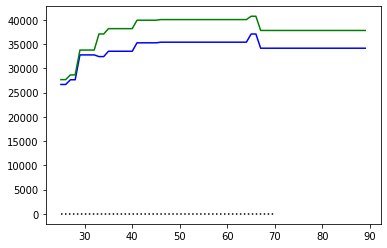

In [378]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE' : 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="b")

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="g")

plt.plot([25,70], [0.5,0.5], color="black", ls=":")
# plt.ylim([0.25,0.75])

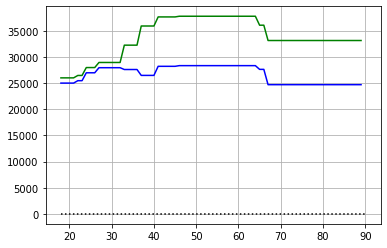

In [390]:
xi = {'OCCUP'  : 8.0,
     'INDUSTRY': 641.0,
     'RACE'    : 'White 800 869, 971',
     'SEX'     : 0.0,
     'HOURS'   : 99.0,
     'AGE'     : 50.0,
     'FERTIL'  : 0.0,
     'WEEK89'  : 52.0,
     'MARITAL' : 0.0,
     'ENGLISH' : 2.0,
     'YRSSERV' : 0.0,
     'MEANS'   : 1.0,
     'CITIZEN' : 1.0,
     'YEARSCH' : 15.0,
     'CLASS'   : 6.0,
     'DEPART'  : 530.0}

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="b")

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="g")

plt.plot([18,90], [0.5,0.5], color="black", ls=":")
plt.grid()
# plt.ylim([0.25,0.75])

In [385]:
df_X['OCCUP'].unique()

array([115, 154, 109,  29, 186,  73,  39,  66,  95,  35, 185, 188, 170,
       189,   0,  77,  57,   1,  10,  64, 101,  72,  25,  58,  96, 145,
        36,  59,  18, 199,  85, 155, 161, 117,  27,  68, 136, 114,  20,
        38,  42,   7,  12,  75,  49,  31,  45,  71,  44,   5,  89, 103,
        55, 156, 121, 194, 182,   4, 158,  51,  43, 175, 183,  74,  70,
       195, 149,  46,  90,  87,  28,  14,  60,  37,  76,  79, 164, 152,
       169, 162, 126,  97, 124,  19,   2,  34,  11,  98,  78, 200, 143,
        61,   3, 165,  33, 193, 197, 138, 184,  65, 159, 111,  50, 181,
        91, 112, 106, 192,  81, 191, 102,  52, 132, 198, 196, 122, 128,
        86,  99, 139,  26, 176,  84, 118,  80, 177,  83, 123,  40, 150,
       129, 105, 110, 130,  15, 151, 172, 146, 160, 179, 178, 116, 144,
         9, 140,  54,   6, 120,  22,  62,  53,  63,  17, 168, 100, 131,
        30,  16,  13, 108, 163, 190, 171, 135,  92,  69,  48, 141, 174,
       125, 113,  67,  93, 167, 157, 137, 142, 147,  88, 148,  2

### Predict where you live, based on attributes

# Deep Learning

- We started simple according to our own rules; but we can now see if deep learning can do better.

- MLP is the appropriate architecture (it is also the simplest)
- We denseley connect all neurons so complex relationships between any two variables can be built
- The dataset size does not justify large models, and we prefer shallow, wide networks

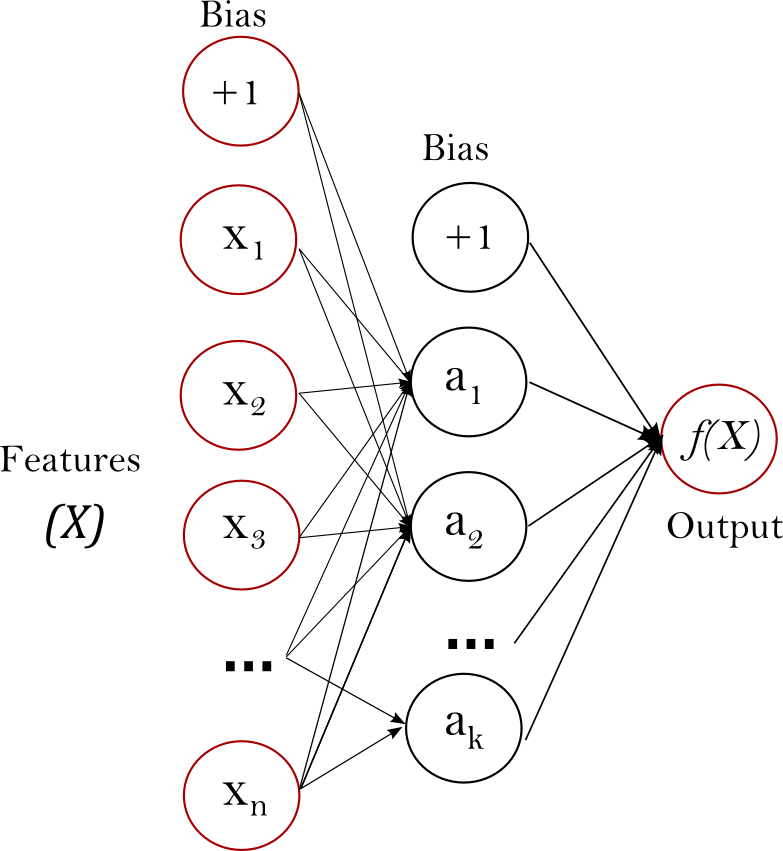

As it turns out, deep learning can achieve good performance but not best without tuning. The expense of the training procedure and the size of the model (and explainability) both count against DL and make something simpler a much better option for this problem.

**Why DL didn't have bets performance**
- Small dataset size
- Mostly linear relationships, don't need DL complexity
- Lack of DL tuning

In [432]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [455]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None,#keep_cols, 
                        cat_cols    = [c for c in df.columns if c not in num_cols],  #[c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None)


Cardinalities
ANCSTRY1                  : 229
ANCSTRY2                  : 157
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 4
FEB55                     : 2
HISPANIC                  : 52
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 494
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 251
POWPUMA                   : 105
POWSTATE                  : 52
RACE                      : 6
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SCHOOL                    : 3
SEPT80                    : 2
SEX 

In [18]:
clf = MLPClassifier(random_state=1, 
                    max_iter=300,
                    verbose=True).fit(X_train, y_train)

/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [456]:
# prove we can overfit to the solution
clf = MLPRegressor(
    hidden_layer_sizes=(60,30),
    random_state=1, 
    max_iter=300,
    learning_rate_init=0.01,
    verbose=True).fit(np.concatenate((X_train, y_train.reshape((-1,1))), axis=1), y_train)

Iteration 1, loss = 3536549.73001955
Iteration 2, loss = 51.24374633
Iteration 3, loss = 13.18545711
Iteration 4, loss = 6.16569760
Iteration 5, loss = 3.79337556
Iteration 6, loss = 106.63510745
Iteration 7, loss = 550.34498309


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [439]:
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test  = scaler.transform(X_test)

(105894, 53)

53

In [465]:
# clf = MLPRegressor(
#     hidden_layer_sizes=(60,30),
#     random_state=1, 
#     max_iter=300,
#     learning_rate_init=0.01,
#     verbose=True).fit(X_train, y_train)

clf = MLPRegressor(
                hidden_layer_sizes=(X_train.shape[1],X_train.shape[1],X_train.shape[1]),
                random_state=1, 
                max_iter=300,
                learning_rate_init=0.01,
                verbose=False)

for i in range(100):
    clf.partial_fit(X_train, y_train)
    print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

$9146.62
$10514.84
$10336.93
$9345.05
$8901.69
$8855.38
$8771.34
$8763.99
$8689.04
$8677.21
$8681.22
$8632.41
$8537.72
$8571.98
$8525.15
$8441.54
$8470.90
$8451.27
$8429.63
$8432.30
$8448.59
$8466.50
$8430.40
$8435.64
$8421.03
$8411.78
$8377.59
$8384.67
$8373.58
$8375.81
$8361.42
$8370.01
$8399.70
$8360.72
$8371.48
$8364.30
$8390.07
$8344.25
$8349.19
$8366.67
$8315.08
$8357.96
$8332.01
$8347.49
$8362.36
$8378.47
$8360.51
$8389.00
$8387.94
$8388.54
$8393.13
$8402.18
$8421.19
$8377.23
$8435.47
$8425.83
$8384.54
$8424.79
$8442.19
$8430.02
$8463.74
$8467.98
$8450.73
$8524.32
$8508.06
$8450.40
$8471.54
$8465.34
$8491.56
$8451.58
$8418.83
$8510.90
$8484.26
$8489.69
$8451.52
$8425.66
$8446.32
$8367.00
$8427.62
$8438.31
$8393.81
$8372.27
$8428.11
$8474.45
$8400.04
$8454.84
$8449.35
$8447.06
$8435.26
$8409.29
$8449.93
$8520.08
$8405.22
$8442.70
$8389.50
$8440.15
$8396.48
$8387.32
$8326.65
$8370.34


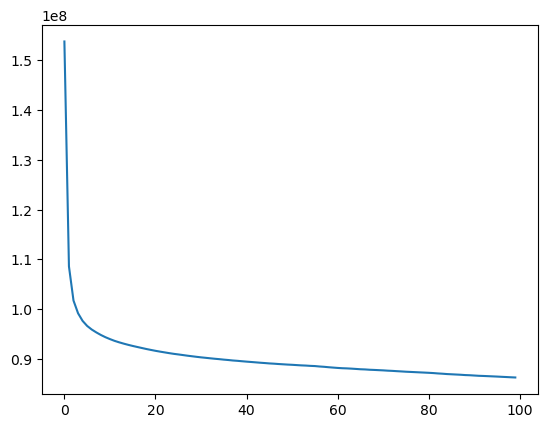

In [464]:
plt.plot(clf.loss_curve_)

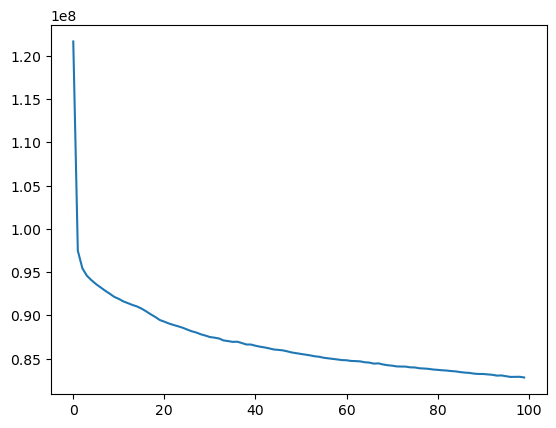

In [ ]:
# lowest loss 82M (60)
# next (60,60) -> 75M, worse test loss

In [442]:
np.abs(clf.predict(X_test) - y_test).mean()

8118.451643501429

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# model = Sequential()
# model.add(Dense(12, input_shape=(8,), activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

## Partial dependence?

array([[3.1000e+01, 7.6000e+01, 1.5600e+02, ..., 1.1100e+02, 8.0000e+00,
        1.0153e+04],
       [3.9000e+01, 2.1300e+02, 1.5600e+02, ..., 3.2000e+01, 3.0000e+00,
        3.9000e+04],
       [4.7000e+01, 9.9000e+01, 1.3000e+01, ..., 2.1000e+01, 2.0000e+00,
        7.2000e+03],
       ...,
       [4.9000e+01, 1.4000e+01, 1.5600e+02, ..., 1.1500e+02, 7.0000e+00,
        4.9000e+04],
       [2.9000e+01, 2.2100e+02, 1.5600e+02, ..., 2.2100e+02, 1.2000e+01,
        3.0000e+04],
       [3.9000e+01, 1.1000e+01, 1.5600e+02, ..., 6.2000e+01, 9.0000e+00,
        3.0000e+04]])

Iteration 1, loss = 2542603.26225022
Iteration 2, loss = 33.07696013
Iteration 3, loss = 10.53239994
Iteration 4, loss = 23.54932258
Iteration 5, loss = 14.97940287
Iteration 6, loss = 126.22058142
Iteration 7, loss = 6400.94476288
Iteration 8, loss = 297.69566388
Iteration 9, loss = 23107.45045905
Iteration 10, loss = 3791.04709429
Iteration 11, loss = 65897.16327854
Iteration 12, loss = 7.82872426


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [53]:
y_train.shape

(109238,)

In [57]:
y_train.reshape((-1,1)).shape

(109238, 1)